In [1]:
#import packages
import tensorflow as tf
from tensorflow.keras import Input, Model, models, layers
from tensorflow.keras.utils import plot_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import randrange, sample

In [2]:
# Load data
import mne
raw = mne.io.read_raw_edf('../EEG_recordings/346/Default_2022-09-21_10_00_27_export_346.edf', preload=True)
#downsample
raw.resample(128)
sf = raw.info['sfreq']
print('Chan =', raw.ch_names)
print('Sampling frequency =', sf)
print('Data shape (channels, times) =', raw._data.shape)
# (128*60*60*23)+(128*60*30)+(128*20) #23hrs + 30min + 20sec
#load sleep scores
scores = pd.read_csv('d:/makinson_lab/sleep/EEG_recordings/346/Default_2022-09-21_10_00_27_export_346_scores.tsv', sep='\t')
# in sirenia sleep, 255 unscored, 1 wake, 2 NREM, 3 REM, 4 "parameters"
# in Yasa -2 = Unscored, -1 = Artefact / Movement, 0 = Wake, 1 = N1 sleep, 2 = N2 sleep, 3 = N3 sleep, 4 = REM sleep
# for sleep scoring code -2 = Unscored, -1 = Artefact / Movement, 0 = Wake, 1 = N1 sleep, 1 = N2 sleep, 1 = N3 sleep, 2 = REM sleep
scores_array = scores['scores']
scores_converted = []
for x in range(scores_array.shape[0]):
    if scores_array[x]==1: # wake
        scores_converted.append(0)
    elif scores_array[x]==2: # NREM
        scores_converted.append(1)
    elif scores_array[x]==3: # REM
        scores_converted.append(2)
    elif scores_array[x]==255: # unscored
        scores_converted.append(-2)
all_scores = scores_converted[0:8460] # 8460: total number of epochs
array_scores = np.array(all_scores).reshape(8460,1)

Extracting EDF parameters from D:\Makinson_lab\sleep\EEG_recordings\346\Default_2022-09-21_10_00_27_export_346.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 86650879  =      0.000 ... 84619.999 secs...
Chan = ['EEG EEG1.1A-B', 'EEG EEG2.1A-B', 'EMG EEG3.1A-B']
Sampling frequency = 128.0
Data shape (channels, times) = (3, 10831360)


In [19]:
test = np.array(CH1)/0.0006
print(test[0])

[ 0.17640349  0.19378858  0.104712   ... -0.04575398 -0.00683689
 -0.05318593]


In [4]:
CH1 = []
CH2 = []
CH3 = []
for i in range(len(all_scores)): # chunking into 10 second arrays
    CH1.append(raw._data[0][i*1280:(i+1)*1280])
    CH2.append(raw._data[1][i*1280:(i+1)*1280])
    CH3.append(raw._data[2][i*1280:(i+1)*1280])
scores_list = array_scores.tolist()

In [5]:
# next three cells are to randomize 60/20/20% 10s chunks into training, dev and test sets
train_CH1 = []
train_CH2 = []
train_CH3 = []
train_scores = []
list_of_numbers = list(range(8460))
for i in range(5076): #60% of 8460
    num = list_of_numbers.pop(randrange(len(list_of_numbers)))
    train_CH1.append(CH1[num])
    train_CH2.append(CH2[num])
    train_CH3.append(CH3[num])
    train_scores.append(scores_list[num])

In [6]:
dev_CH1 = []
dev_CH2 = []
dev_CH3 = []
dev_scores = []
for i in range(1692): #20% of 8460
    num = list_of_numbers.pop(randrange(len(list_of_numbers)))
    dev_CH1.append(CH1[num])
    dev_CH2.append(CH2[num])
    dev_CH3.append(CH3[num])
    dev_scores.append(scores_list[num])

In [7]:
test_CH1 = []
test_CH2 = []
test_CH3 = []
test_scores = []
for i in range(1692): #20% of 8460
    num = list_of_numbers.pop(randrange(len(list_of_numbers)))
    test_CH1.append(CH1[num])
    test_CH2.append(CH2[num])
    test_CH3.append(CH3[num])
    test_scores.append(scores_list[num])

0.0006192850022563561


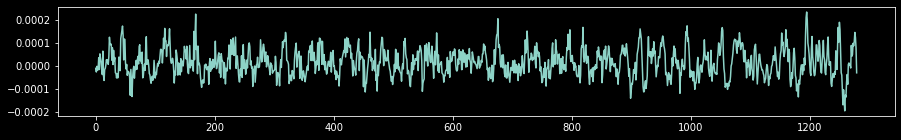

In [20]:
fig = plt.figure(figsize=(15,2))
plt.style.use('dark_background')
plt.plot(CH1[8459])
print(np.max(test_CH3))

In [7]:
# train_CH1_check = np.array(CH1[0:2629])
# train_CH2_check = np.array(CH2[0:2629])
# train_CH3_check = np.array(CH3[0:2629])

# dev_CH1_check = np.array(CH1[2629:3505])
# dev_CH2_check = np.array(CH2[2629:3505])
# dev_CH3_check = np.array(CH3[2629:3505])

# test_CH1_check = np.array(CH1[3505:4384])
# test_CH2_check = np.array(CH2[3505:4384])
# test_CH3_check = np.array(CH3[3505:4384])

# train_scores_check = array_scores[0:2629]
# dev_scores_check = array_scores[2629:3505]
# test_scores_check = array_scores[3505:4384]

In [8]:
def get_uncompiled_model():
    input_EEG1 = Input(shape=(1280,), name = 'EEG1')
    input_EEG2 = Input(shape=(1280,), name = 'EEG2')
    input_EMG = Input(shape=(1280,), name = 'EMG')
    inputs = layers.concatenate([input_EEG1, input_EEG2, input_EMG], name = 'combined_inputs')
    x = layers.Dense(15, activation = "relu", name = 'layer_1')(inputs)
    x = layers.Dense(10, activation = "relu", name = 'layer_2')(x)
    outputs = layers.Dense(3, activation = "linear", name = 'outputs')(x)
    model = Model(inputs = [input_EEG1, input_EEG2, input_EMG], outputs = [outputs], name = 'sleep_scoring_model')
    return model

def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = ["accuracy"],
    )
    return model

In [9]:
model = get_compiled_model()

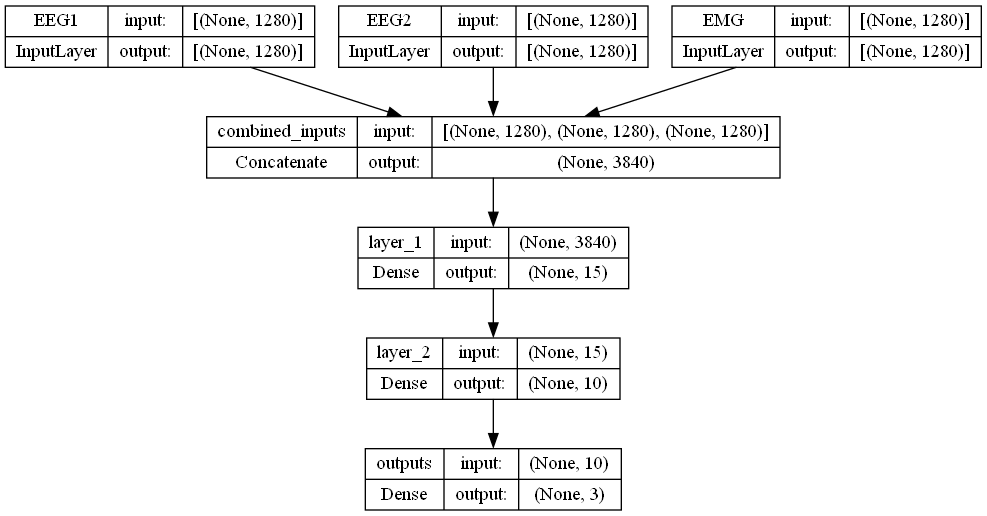

In [10]:
plot_model(model, 'multi_input_neural_network.png', show_shapes=True, show_layer_names=True)

In [11]:
model.summary()

Model: "sleep_scoring_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 EEG1 (InputLayer)              [(None, 1280)]       0           []                               
                                                                                                  
 EEG2 (InputLayer)              [(None, 1280)]       0           []                               
                                                                                                  
 EMG (InputLayer)               [(None, 1280)]       0           []                               
                                                                                                  
 combined_inputs (Concatenate)  (None, 3840)         0           ['EEG1[0][0]',                   
                                                                  'EEG2[0][0]', 

In [12]:
EEG1 = []
for array in train_CH1:
    max_abs = max(abs(array))
    EEG1.append(array/max_abs)
X_EEG1 = np.array(EEG1)

EEG2 = []
for array in train_CH2:
    max_abs = max(abs(array))
    EEG2.append(array/max_abs)
X_EEG2 = np.array(EEG2)

# EMG = []
# for array in train_CH3:
#     max_abs = max(abs(array))
#     EMG.append(array/max_abs)
X_EMG = np.array(train_CH3)*10000

y = np.array(train_scores)

In [24]:
np.max((np.array(train_CH3)))

0.0005822857790928009

In [13]:
history = model.fit({'EEG1':X_EEG1, 'EEG2':X_EEG2, 'EMG': X_EMG},
                    {'outputs': y},
    epochs=100
)

Epoch 1/100
159/159 [==============================] - 2s 5ms/step - loss: 0.6546 - accuracy: 0.7039
Epoch 2/100
159/159 [==============================] - 1s 5ms/step - loss: 0.3992 - accuracy: 0.8548
Epoch 3/100
159/159 [==============================] - 1s 5ms/step - loss: 0.2816 - accuracy: 0.8950
Epoch 4/100
159/159 [==============================] - 1s 5ms/step - loss: 0.1882 - accuracy: 0.9385
Epoch 5/100
159/159 [==============================] - 1s 5ms/step - loss: 0.1124 - accuracy: 0.9712
Epoch 6/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0651 - accuracy: 0.9878
Epoch 7/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0369 - accuracy: 0.9941
Epoch 8/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0214 - accuracy: 0.9968
Epoch 9/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0138 - accuracy: 0.9972
Epoch 10/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0098 - accura

159/159 [==============================] - 1s 5ms/step - loss: 0.0045 - accuracy: 0.9994
Epoch 81/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0032 - accuracy: 0.9994
Epoch 82/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0025 - accuracy: 0.9994
Epoch 83/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0021 - accuracy: 0.9998
Epoch 84/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0018 - accuracy: 0.9998
Epoch 85/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0016 - accuracy: 0.9996
Epoch 86/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0015 - accuracy: 0.9998
Epoch 87/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0014 - accuracy: 0.9998
Epoch 88/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0013 - accuracy: 0.9998
Epoch 89/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0012 - accuracy: 

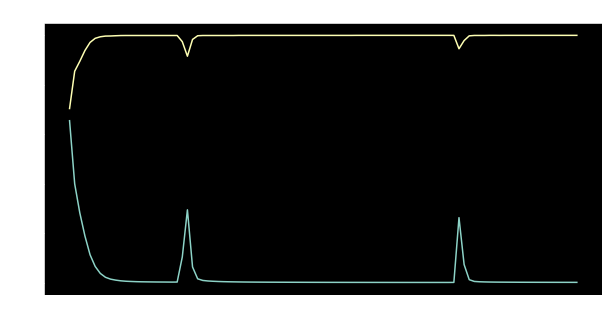

In [14]:
fig = plt.figure(figsize = [10,5])
plt.style.use('dark_background')
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('loss/accuracy')
plt.title('Learning Curve')
plt.show()

In [16]:
EEG1 = []
for array in dev_CH1:
    max_abs = max(abs(array))
    EEG1.append(array/max_abs)
X_EEG1 = np.array(EEG1)

EEG2 = []
for array in dev_CH2:
    max_abs = max(abs(array))
    EEG2.append(array/max_abs)
X_EEG2 = np.array(EEG2)

EMG = []
for array in dev_CH3:
    max_abs = max(abs(array))
    EMG.append(array/max_abs)
X_EMG = np.array(EMG)

y = np.array(dev_scores)

dev_scores = model.evaluate(x=[X_EEG1,X_EEG2,X_EMG],
                            y=y, 
                           verbose = 2
                           )

53/53 - 0s - loss: 1.6575 - accuracy: 0.7719 - 256ms/epoch - 5ms/step


In [42]:
# model.save('test_model')

INFO:tensorflow:Assets written to: test_model\assets


INFO:tensorflow:Assets written to: test_model\assets


In [169]:
train_EEG = np.array(train_CH1)
train_EMG = np.array(train_CH3)
train_y = np.array(train_scores)
# for sleep scoring code -2 = Unscored, -1 = Artefact / Movement, 0 = Wake, 1 = N1 sleep, 1 = N2 sleep, 1 = N3 sleep, 2 = REM sleep
y_hat = []
for x in range(train_EEG.shape[0]):
    prediction = model.predict([train_EEG[x].reshape(1,1280), train_EMG[x].reshape(1,1280)])
    prediction_p = tf.nn.softmax(prediction)
    y_hat.append(np.argmax(prediction_p))
yhat = np.array(y_hat).reshape(len(y_hat),1)
equals = yhat==train_y
sum(equals)/len(y_hat)

In [172]:
dev_EEG = np.array(dev_CH1)
dev_EMG = np.array(dev_CH3)
dev_y = np.array(dev_scores)
# for sleep scoring code -2 = Unscored, -1 = Artefact / Movement, 0 = Wake, 1 = N1 sleep, 1 = N2 sleep, 1 = N3 sleep, 2 = REM sleep
y_hat = []
for x in range(dev_EEG.shape[0]):
    prediction = model.predict([dev_EEG[x].reshape(1,1280), dev_EMG[x].reshape(1,1280)])
    prediction_p = tf.nn.softmax(prediction)
    y_hat.append(np.argmax(prediction_p))
yhat = np.array(y_hat).reshape(len(y_hat),1)
equals = yhat==dev_y
sum(equals)/len(y_hat)

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


array([0.65906499])